In [236]:
import requests
import random

import numpy as np
import pandas as pd
import seaborn as sns

import descartes
import geopandas as gpd

from bokeh.plotting import figure, output_file, show, save
from bokeh.models import GeoJSONDataSource

from shapely.geometry import Point, MultiPolygon
from shapely.geometry.polygon import Polygon, LinearRing

In [148]:
def create_grid_points(size=100, prnt=False):
    """
    This function returns coordinates in the form of a grid of coordinates that fall within the inhabited
    parts of Amsterdam. These points can function as samples to calculate average walking distance to nearest container.
    """
    
    street_map = gpd.read_file('../data/woonbc12_region.shp')
    true_points = []
    points = []
    for i in range(110000, 135000, size):
        for j in range(475000, 495000, size):
            points.append(Point(i, j))

    for k in range(street_map.shape[0]):
        try:
            polygon = MultiPolygon(street_map['geometry'].iloc[k]) # If neighborhood is multiple seperated pieces
        except:
            polygon = Polygon(street_map['geometry'].iloc[k]) # Other cases
        [true_points.append(point) for point in points if polygon.contains(point) == True]
        if prnt:
            print(len(true_points))
    return true_points

In [93]:
def load_data(pages = 725, save=False):
    """
    Loops through all pages of the API of garbage containers and stores these in a DF.
    The fraction and coordinates are saved with the unique id.
    """

    # Formation of variables to be filled in loop
    containers = []
    coordinates = []
    type_vuil = []
    counter = 0
    container_ids = []
    lons_new = []
    lats_new = []

    # Initial link to send GET request to
    link = 'https://api.data.amsterdam.nl/vsd/afvalcontainers'

    # While loop to get all pages
    while link != None and counter < pages: #100 as limit for testing purpose
        counter += 1 #Update counter
        response = requests.get(link) # Send request
        output = response.json()
        for result in output['results']:
            try:
                containers.append(result)
                container_ids.append(result['container_id'])
    #             lons_new.append(float(result['container_wgs84_lon']))
    #             lats_new.append(float(result['container_wgs84_lat']))
                lons_new.append(result['container_geometrie']['coordinates'][0])
                lats_new.append(result['container_geometrie']['coordinates'][1])
                type_vuil.append(result['container_afvalfractie'])
            except:
                print('a')
                pass 
        try:
            link = output['_links']['next']['href'] # Get link to next page

        except:
            link = None

    df= pd.DataFrame([container_ids, lons_new, lats_new, type_vuil]).T.rename(columns={0: 'id', 1:'x', 2:'y', 3:'fractie'})
    
    if save:
        df.to_csv('/../data/containers.csv')
    return df, containers

In [94]:
df, containers = load_data(pages=725)

a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a


In [149]:
grid_points = create_grid_points()

In [211]:
df_textiel = df[df['fractie'] == 'Textiel']
df_glas = df[df['fractie'] == 'Glas']
df_papier = df[df['fractie'] == 'Papier']
df_plastic = df[df['fractie'] == 'Plastic']
df_rest = df[df['fractie'] == 'Rest']

In [317]:
def distance_from_gridpoint_to_container(grid_point, container_x, container_y):
    """
    Calculates Euclidian distance between grid_point and container selected.
    Returns distance in coordinates WGS84
    """
    grid_point = np.asarray(grid_point)
    container = np.asarray([container_x, container_y])
    dist = np.linalg.norm(grid_point-container)
    return dist

def shortest_distance_to_container(grid_point, containers):
    lowest = 999999999999
    nearest_container = None
    # Decrease the radius of containers to speed up computing
    containers = containers[(containers['x'] - 2000 < grid_point.coords[0][0]) & (containers['x'] + 2000 > grid_point.coords[0][0])&\
                           (containers['y'] - 2000 < grid_point.coords[0][1]) & (containers['y'] + 2000 > grid_point.coords[0][1])]
    for i in range(containers.shape[0]):
        dist = distance_from_gridpoint_to_container(grid_point, containers.iloc[i]['x'], containers.iloc[i]['y'])
        if dist < lowest:
            lowest = dist
            nearest_container = i
    return lowest, nearest_container

def shortest_distance_to_container_all_points(grid_points, containers, sample_size=10):
    lst_total = []
    
    random.shuffle(grid_points)
    for point in grid_points[:sample_size]:
        temp= list(shortest_distance_to_container(point, containers))
        temp.append(point)
        lst_total.append(temp)

    return pd.DataFrame(lst_total).rename(columns={0:'distance', 1:'nearest_container', 2:'coordinates'})

def calculate_score(df, grid_points, repetitions=10, sample_size=10, show_plot=True, statistics=True):
    
    # Devide dataframe in different fractions
    df_textiel = df[df['fractie'] == 'Textiel']
    df_glas = df[df['fractie'] == 'Glas']
    df_papier = df[df['fractie'] == 'Papier']
    df_plastic = df[df['fractie'] == 'Plastic']
    df_rest = df[df['fractie'] == 'Rest']
    
    # Create list to append scores to
    scores = []
    penalties = 0 
    
    for i in range(repetitions):    
        total = [shortest_distance_to_container_all_points(grid_points, df_glas)['distance'].mean(),\
                 shortest_distance_to_container_all_points(grid_points, df_textiel)['distance'].mean(),\
                 shortest_distance_to_container_all_points(grid_points, df_papier)['distance'].mean(),\
                 shortest_distance_to_container_all_points(grid_points, df_plastic)['distance'].mean(),\
                 shortest_distance_to_container_all_points(grid_points, df_rest)['distance'].mean()]
        score = 0.15 * total[0] + 0.05 * total[1] + 0.2 * total[2] + 0.25 * total[3] + 0.35 * total[4]
        if score < 500:
            scores.append(score)
#         print(score, total[0], total[1], total[2], total[3], total[4])
        else:
            penalties += 1
            print(penalties, score, total[0], total[1], total[2], total[3], total[4])
        
    # Series for statistics and plot
    scores_series = pd.Series(scores)
        
    if show_plot:
        sns.distplot(scores_series).set(title='distribution of score functions (n=10)', xlabel='d_w in meters')
    
    if statistics:
        print(scores_series.mean(), scores_series.median(), scores_series.std())
    
    return scores
    
        

174.5401637116778 129.07738634608978 246.9860336087122 88.75176042163375 129.98716699745964 264.52031498753445
136.7443036335933 117.03643503217442 137.48147843570555 87.66509778555316 156.16382382004429 159.25939698531465
150.92776690088394 114.46141189310747 290.6840245248269 124.66139860758044 225.37944371536395 108.42060925805545
119.633196681562 151.1443629467382 259.48877672658966 92.61137274750062 161.69422574568395 71.54649262085901
227.36044775964103 128.44353332759562 224.25352175382136 145.92796424011613 117.78244200458798 395.0001094961155
168.2340805745817 149.16414054666714 207.68830359372342 105.98565978596159 313.74134504932033 102.40736026678019
144.743750931914 107.79750241317576 303.9667461484331 179.60940100587496 161.39176453586475 106.01704836392807
112.54324102444642 85.88256527655352 393.200998762607 68.88908432565678 116.85947714834087 105.73748612176132
133.1426120646995 130.8348439177865 275.8770480512047 106.34215739883575 194.07083619595355 85.5354072734736

[174.5401637116778,
 136.7443036335933,
 150.92776690088394,
 119.633196681562,
 227.36044775964103,
 168.2340805745817,
 144.743750931914,
 112.54324102444642,
 133.1426120646995,
 108.61857811812686]

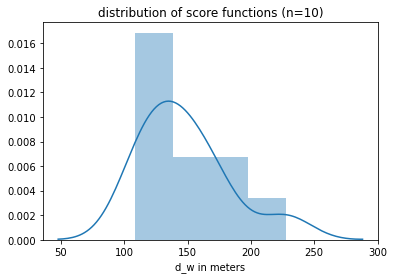

In [311]:
calculate_score(df, grid_points)

In [252]:
grid_points[0].coords[0]

(115700.0, 484300.0)

In [296]:
scores_series.mean(), scores_series.median(), scores_series.std()

(128.24990100571455, 124.17152268779357, 23.706171528048742)

### Random Algorithm

In [297]:
# Make a copy for shuffling
df_shuffled = df.copy()

132.09386512437706 135.187081577196 17.37402749369987
139.88212236786654 132.2111164745225 32.500234797781275
1
135.24310732531697 126.12527453596991 16.695073158966668
1
144.31922557614234 132.36712675533752 26.588537744074472
135.00104924857038 126.69188947996179 22.47695394237623
1
2
125.74934851423444 131.07718258404725 17.430278980766037
138.7997951931069 129.6567511485766 26.698164196222116
135.37629980637473 136.57637365623847 17.191866706393792
1
132.05143465220596 133.11270811899078 19.23500562534172
132.84963104524877 130.22310958206367 15.958023302959598


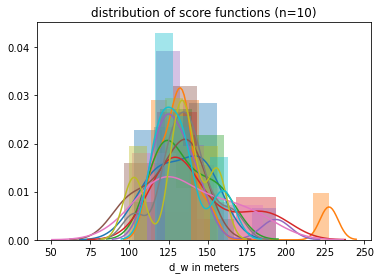

In [316]:
for i in range(10):
    fractions = list(df_shuffled['fractie'])
    random.shuffle(fractions)
    df_shuffled['fractie'] = fractions
    calculate_score(df_shuffled, grid_points)